In [ ]:
from transformers import TrainingArguments, Trainer
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments
from peft import PeftModel, LoraConfig, prepare_model_for_kbit_training, get_peft_model
from datasets import load_dataset, Dataset
import polars as pl
from unsloth import FastLanguageModel


In [2]:
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# adapter_path = '/home/lawrence/Projects/my_models/mistral_pr_lora_over65'

In [4]:
# seems to be an issue with loading multiple adpaters with unsloth... and loading the unsloth adapater with regular model
# 2 - might want to train 

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/mistral-7b-instruct-v0.2-bnb-4bit", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    cache_dir = "/gpfs/home/yiyayu/scratch/cache"
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = True,
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

# # Load the adapter.
# model = PeftModel.from_pretrained(
#     model,
#     adapter_path,
#     is_trainable=True,
#     adapter_name="train",
# )
# # Load the adapter a second time, with a different name, which will be our reference model.
# model.load_adapter(adapter_path, adapter_name="reference")

config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Mistral patching release 2024.4
   \\   /|    GPU: NVIDIA A100 80GB PCIe. Max memory: 79.151 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.1.2+cu121. CUDA = 8.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.23.post1. FA = True.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

Unsloth 2024.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [5]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "mistral", # Supports zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, unsloth
    map_eos_token = True, # Maps <|im_end|> to </s> instead
)

In [6]:
orig_prefix = "Original Text:"
rewrite_prefix = "Rewritten Text:"
response_start = "The prompt was:"
sys_prompt = """You are an expert in "Reverse Prompt Engineering". You are able to reverse-engineer prompts used to rewrite text. 

I will be providing you with an "original text" and "rewritten text". Please try to be as specific as possible and come up with a prompt that is based on the tone, style, and any other properties you consider relevant."""

def format_prompts(x):
    messages = [
        {"role": "user", "content": f"{sys_prompt}\n{orig_prefix} {x['original_text']}\n{rewrite_prefix} {x['rewritten_text']}"},
        {"role": "assistant", "content": f"{response_start} "}
    ]
    output = tokenizer.apply_chat_template(messages, tokenize = False, add_generation_prompt = False).rstrip('</s>')
    return {"prompt": output}

In [26]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('./data/exp_test/multi_n_with_lora3/multi_n_scored.csv')

# Create the new column 'final_prompt'
def select_prompt(row):
    if row['score_1'] > row['score_2']:
        return row['rewrite_prompt_1']
    else:
        return row['rewrite_prompt_2']

df['rejected'] = df.apply(select_prompt, axis=1)

# Create the new column 'chosen' by copying 'gt_rewrite_prompt'
df['chosen'] = df['gt_rewrite_prompt']

# Save the updated DataFrame to a new CSV file
df.to_csv('./data/exp_test/multi_n_with_lora3/multi_n_scored2.csv', index=False)

In [29]:
def format_prompts_pandas(df):
    """
    Applies the format_prompts function to each row of a pandas DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the required columns.

    Returns:
        pandas.DataFrame: A new DataFrame with a 'prompt' column containing the formatted prompts.
    """
    prompts = []
    for _, row in df.iterrows():
        messages = [
            {"role": "user", "content": f"{sys_prompt}\\n{orig_prefix} {row['original_text']}\\n{rewrite_prefix} {row['rewritten_text']}"},
            {"role": "assistant", "content": f"{response_start} "}
        ]
        output = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False).rstrip('</s>')
        prompts.append({"prompt": output})

    return pd.DataFrame(prompts)

# Assuming you have a pandas DataFrame 'dataset' with the required columns
df = df.join(format_prompts_pandas(df))

In [32]:
# Extract the required columns
new_df = df[['prompt', 'chosen', 'rejected']]

# Rename the columns
new_df.columns = ['prompt', 'chosen', 'rejected']

# Save the new DataFrame to a CSV file
new_df.to_csv('./data/exp_test/multi_n_with_lora3/multi_n_scored2.csv', index=False)

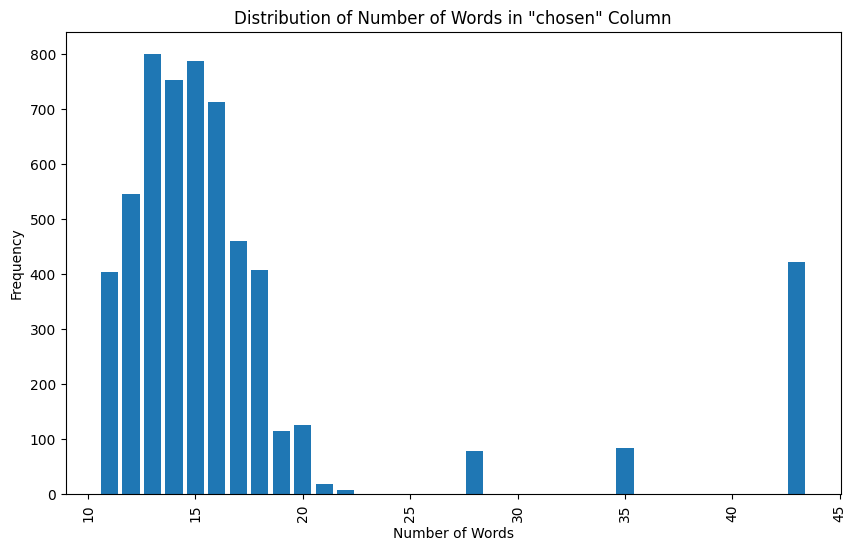

In [55]:
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('./data/exp_test/multi_n_with_lora3/multi_n_scored3.csv')

# Count the number of words in each cell of the 'chosen' column
word_counts = df['chosen'].apply(lambda x: len(x.split()))

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(word_counts.value_counts().index, word_counts.value_counts().values)
ax.set_xlabel('Number of Words')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Number of Words in "chosen" Column')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Show the plot
plt.show()

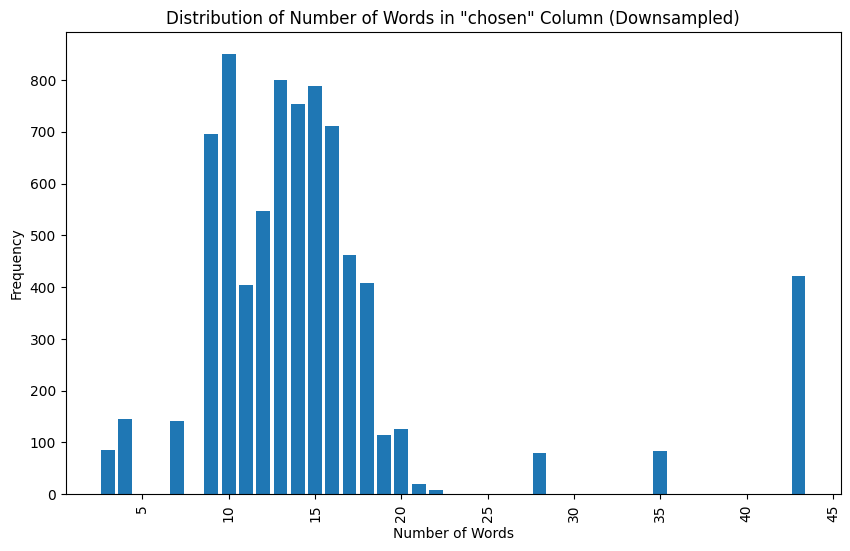

In [45]:
# Count the number of words in each cell of the 'chosen' column
word_counts = df['chosen'].apply(lambda x: len(x.split()))

# Downsample the data where word_counts is 7 to 20%
downsample_mask = word_counts == 8
downsample_size = int(downsample_mask.sum() * 0.4)
downsampled_data = df.loc[downsample_mask.sample(frac=1).iloc[:downsample_size].index]

# Combine the downsampled data with the rest of the data
df = pd.concat([downsampled_data, df.loc[~downsample_mask]])

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(word_counts.value_counts().index, word_counts.value_counts().values)
ax.set_xlabel('Number of Words')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Number of Words in "chosen" Column (Downsampled)')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [56]:
num_samples_gt_20 = (word_counts > 15).sum()

print(f"Number of samples with word_counts greater than 20: {num_samples_gt_20}")

Number of samples with word_counts greater than 20: 2432


In [46]:
# Filter the DataFrame to include only samples with word_counts greater than 10
word_counts = df['chosen'].apply(lambda x: len(x.split()))
filtered_df = df[word_counts > 10]

# Save the filtered DataFrame to a new CSV file
filtered_df.to_csv('./data/exp_test/multi_n_with_lora3/multi_n_scored3.csv', index=False)

In [16]:
# df = pl.read_csv('./data/predictions/combined-filtered_*.csv', ignore_errors=True)
df = pl.read_csv('./data/exp_test/multi_n_with_lora3/multi_n_scored2.csv', ignore_errors=True)
dataset = Dataset.from_list(df.to_dicts())
dataset = dataset.map(format_prompts)
dataset.remove_columns(['original_text', 'rewritten_text', 'gt_rewrite_prompt', 'old_rewrite_prompt','score','input','rewrite_prompts','rewrite_prompt_1','rewrite_prompt_2','score_1','score_2'])

Map:   0%|          | 0/9983 [00:00<?, ? examples/s]

Dataset({
    features: ['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'rejected', 'chosen', 'prompt'],
    num_rows: 9983
})

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,original_text,gt_rewrite_prompt,rewritten_text,input,old_rewrite_prompt,score,rewrite_prompts,rewrite_prompt_1,rewrite_prompt_2,score_1,score_2,rejected,chosen
0,0,39,394,Figure 9.3 This car is in dynamic equilibrium ...,Turn this paragraph into a set of guidelines f...,The text does not contain any information abou...,"<s>[INST] You are an expert in ""Reverse Prompt...",I cannot fulfill this prompt as the original ...,0.509424,"[' ""Given a text describing a physical phenome...","""Given a text describing a physical phenomeno...","""Given a text describing physics concepts rel...",0.824800,0.768895,"""Given a text describing a physical phenomeno...",Turn this paragraph into a set of guidelines f...
1,1,40,453,"Science rests on evidence and logic, so it dea...",Create a dialogue between two characters discu...,"Sure, here's the dialogue:\n\nCharacters: Sara...","<s>[INST] You are an expert in ""Reverse Prompt...",Write a script for a dialogue between two cha...,0.588464,"[' ""Write a dialog between two characters disc...","""Write a dialog between two characters discus...","""Write a dialogue between two characters disc...",0.719603,0.727570,"""Write a dialogue between two characters disc...",Create a dialogue between two characters discu...
2,2,41,53,Introduction The environment consists of numer...,Rewrite the following sentence in simpler terms,"Sure, here's the rewritten sentence in simpler...","<s>[INST] You are an expert in ""Reverse Prompt...","Simplify the text, making it easily understan...",0.560307,"[' ""Rewrite the following text into simpler la...","""Rewrite the following text into simpler lang...","""_Describe the function and components of the...",0.725282,0.582107,"""Rewrite the following text into simpler lang...",Rewrite the following sentence in simpler terms
3,3,42,388,Figure 21.13 Extinction intensity as reflected...,Translate this technical sentence into plain E...,"Sure, here's the translation:\n\nThe fossil re...","<s>[INST] You are an expert in ""Reverse Prompt...","Rewrite the text in simple, clear language fo...",0.462264,"[' ""Translate the following academic text into...","""Translate the following academic text into a...","""Translate the following scientific passage i...",0.488263,0.570618,"""Translate the following scientific passage i...",Translate this technical sentence into plain E...
4,4,43,695,"Not only salt, but many other solutes can diss...",Turn this into a script for a cooking show.,## The Salty Kitchen: Water's Power\n\n**Scene...,"<s>[INST] You are an expert in ""Reverse Prompt...",Provide a dialogue script for an educational ...,0.673553,"[' ""Develop a script for a scene in a kitchen ...","""Develop a script for a scene in a kitchen se...","""_Create a title and a short scene in a kitch...",0.701201,0.581864,"""Develop a script for a scene in a kitchen se...",Turn this into a script for a cooking show.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9978,9978,9978,1,"All amphibians have digestive, excretory, and ...",Translate this technical sentence into plain E...,"Sure, here's the translated sentence into plai...","<s>[INST] You are an expert in ""Reverse Prompt...",Simplify and clarify this scientific text for...,0.484933,"[' ""Translate the given text about amphibians\...","""Translate the given text about amphibians' o...","""Translate the given text into plain English,...",0.579571,0.648444,"""Translate the given text into plain English,...",Translate this technical sentence into plain E...
9979,9979,9979,262,Facilitated diffusion is the diffusion of solu...,Transform this information into the outline fo...,"**Outline of a New Social Movement: ""Facilitat...","<s>[INST] You are an expert in ""Reverse Prompt...",Transform the text into a proposal for a new ...,0.645402,"[' ""Rewrite the given text in the form of a pr...","""Rewrite the given text in the form of a pres...",distinctive tone of a call to action or advoc

In [ ]:
# needs dpo code

In [ ]:
trainer_stats = trainer.train()


In [ ]:
# model.save_pretrained('/home/lawrence/Projects/my_models/mistral_pr_lora_over65v2b')